# How Well Are Our Suppliers Doing?

## 1. Intro
The dataset consists of four tables: Orders, Items, Receipts, and Inspection stored in a SQLite database. These tables simulate the beginning to end process of placing and order, tracking is receipt, and acceptance by inspection. 

The goal is to solely use SQL to analyze supplier performance, and make note of any issues or trends.

## 2. Setup
We will perform the analysis inside a Jupyter notebook using the SQL magic extension. This will allow for the seamless use of SQL queries with python visualization libraries.

We'll first enable the SQL magic extension and establish a connection to the database.

In [189]:
%load_ext sql
%sql sqlite:///synthetic_erp.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


Checking the connection and sql magic commmands with a query for the table names.

In [190]:
%%sql
SELECT name 
FROM sqlite_master 
WHERE type='table'

 * sqlite:///synthetic_erp.db
Done.


name
items
orders
receipts
inspections


We have the tables we need, now we will move on to modeling our data.

## 3. Data Structure and Joining
To use the data we first need to understand the structure of the data:
* The orders table contains a set of unique orders, each for a one part number, some quantity and due date
* The items table defines the unique product number, its description, commodity type and criticality to the business
* The receipt table contains information about when and what quantity of material has been received for an order. There is a many-to-one relationship between receipts and orders; An order will have multiple receipts.
* The inspections table tells us when the parts where inspected and how many were accepted and rejected. There is only one inspection per receipt, so a one-to-one relationship exists between the inspections and receipt table.

Now that we know how the data is structure we can create our JOIN query to pull the data from all tables.

In [191]:
query = '''
SELECT  
    receipts.id AS 'receipt_id',
    receipts.quantity_received,	
    receipts.received_date,

    orders.order_number,
    orders.vendor,
    orders.product_number,
    orders.quantity,
    orders.due_date,

    items.product_description,
    items.commodity_type,
    items.criticality,

    inspections.inspection_date,
    inspections.quantity_inspected,
    inspections.quantity_accepted,
    inspections.quantity_rejected,
    inspections.rejected,
    inspections.defect_code

FROM receipts
LEFT JOIN inspections ON inspections.receipt_number = receipts.id
LEFT JOIN orders ON orders.order_number = receipts.order_number
LEFT JOIN items ON orders.product_number = items.id
LIMIT 5
'''
result = %sql {query}

result

 * sqlite:///synthetic_erp.db
Done.


receipt_id,quantity_received,received_date,order_number,vendor,product_number,quantity,due_date,product_description,commodity_type,criticality,inspection_date,quantity_inspected,quantity_accepted,quantity_rejected,rejected,defect_code
1,2,2023-12-16 00:00:00,PO-909,Wayne Enterprises,9,91,2024-01-03 00:00:00,Pip-Boy,Electrical,Low,2023-12-26 00:00:00,2,2,0,0,None
2,4,2023-12-16 00:00:00,PO-939,Wayne Enterprises,2,50,2024-01-05 00:00:00,Flux Capacitor,Electronic,High,2023-12-21 00:00:00,4,4,0,0,None
3,30,2023-12-17 00:00:00,PO-909,Wayne Enterprises,9,91,2024-01-03 00:00:00,Pip-Boy,Electrical,Low,2023-12-22 00:00:00,3,30,0,0,None
4,85,2023-12-17 00:00:00,PO-755,Wayne Enterprises,2,90,2024-01-05 00:00:00,Flux Capacitor,Electronic,High,2023-12-18 00:00:00,8,85,0,0,None
5,42,2023-12-19 00:00:00,PO-023,Wayne Enterprises,6,80,2024-01-06 00:00:00,Batarang,Mechanical,Low,2024-01-01 00:00:00,4,42,0,0,None


Our joins followed the reasoning below:
* We first query from receipts since it is our lowest level of granularity
* From there we join it with the inspection data (1-to-1 )
* For each receipt, we join each records with the data in the orders table (Many-to-1)
* And finally, for each order there is corresponding item data which is the final join (1-to-1)

### Creating a View
To simplify the task of querying all of the tables, a view is created called _summary_view_.

In [192]:
%%sql
CREATE VIEW IF NOT EXISTS summary_view AS

SELECT  
    receipts.id AS 'receipt_id',
    receipts.quantity_received,	
    receipts.received_date,

    orders.order_number,
    orders.vendor,
    orders.product_number,
    orders.quantity,
    orders.due_date,

    items.product_description,
    items.commodity_type,
    items.criticality,

    inspections.inspection_date,
    inspections.quantity_inspected,
    inspections.quantity_accepted,
    inspections.quantity_rejected,
    inspections.rejected,
    inspections.defect_code

FROM receipts
LEFT JOIN inspections ON inspections.receipt_number = receipts.id
LEFT JOIN orders ON orders.order_number = receipts.order_number
LEFT JOIN items ON orders.product_number = items.id

 * sqlite:///synthetic_erp.db
Done.


[]

We'll query the new view to see if everything checks out.

In [193]:
%%sql
SELECT * FROM summary_view
LIMIT 3

 * sqlite:///synthetic_erp.db
Done.


receipt_id,quantity_received,received_date,order_number,vendor,product_number,quantity,due_date,product_description,commodity_type,criticality,inspection_date,quantity_inspected,quantity_accepted,quantity_rejected,rejected,defect_code
1,2,2023-12-16 00:00:00,PO-909,Wayne Enterprises,9,91,2024-01-03 00:00:00,Pip-Boy,Electrical,Low,2023-12-26 00:00:00,2,2,0,0,None
2,4,2023-12-16 00:00:00,PO-939,Wayne Enterprises,2,50,2024-01-05 00:00:00,Flux Capacitor,Electronic,High,2023-12-21 00:00:00,4,4,0,0,None
3,30,2023-12-17 00:00:00,PO-909,Wayne Enterprises,9,91,2024-01-03 00:00:00,Pip-Boy,Electrical,Low,2023-12-22 00:00:00,3,30,0,0,None


Perfect, our new view has been created. Now we are ready to start analyzing our suppliers' performance

## 4. Supplier Performance
For this analyses we will calculate the quality rating, on time delivery rating, and generate a risk matrix using only SQL.

### Quality Rating
**Quality rating** is a ubiquitous metric to track how consistently a supplier delivers conforming product.

The SQL query below will divided the number of accepted parts by the number of total parts received the create the quality rating metric. We will have one query for all vendors the perform a UNION operation with a queried table for the rating by vendor and month, to compare each vendors rating with the overall rating.

In [194]:

query = '''
SELECT
    'All Vendors' AS vendor,
    strftime('%m', inspection_date) AS month,
    SUM(quantity_accepted) AS total_accepted,
    SUM(quantity_received) AS total_received,
    ROUND(
        sum(quantity_accepted) * 1.0 / sum(quantity_received),
        3) AS quality_rating
FROM summary_view
GROUP BY month

UNION ALL

SELECT
    vendor,
    strftime('%m', inspection_date) AS month,
    SUM(quantity_accepted) AS total_accepted,
    SUM(quantity_received) as total_received,
    ROUND(
        sum(quantity_accepted) * 1.0 / sum(quantity_received),
        3) AS quality_rating
FROM summary_view
GROUP BY vendor, month
'''
result = %sql {query}

quality_df = result.DataFrame()
quality_df.head(10)
quality_df.drop_duplicates(subset='vendor', keep='first').head(6)

 * sqlite:///synthetic_erp.db
Done.


,vendor,month,total_accepted,total_received,quality_rating
0,All Vendors,01,2664,3220,0.827
12,Acme Corporation,01,373,381,0.979
24,Erebor Heavy Industries,01,317,327,0.969
36,Vault-Tec,01,803,1208,0.665
48,Wayne Enterprises,01,529,560,0.945
60,Weyland-Yutani Corp,01,642,744,0.863


### Plot of Quality Rating

Now that we have the total and individual supplier quality ratings, we will analyze the data by creating straightforward plots of the quality rating over time.

Our business requires suppliers to have a quality rating of 90% at a minimum. Anything below 90% is unsatisfactory and is denoted using red diamond markers on our plot.

In [195]:
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
plt.rcParams['figure.dpi'] = 150 
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

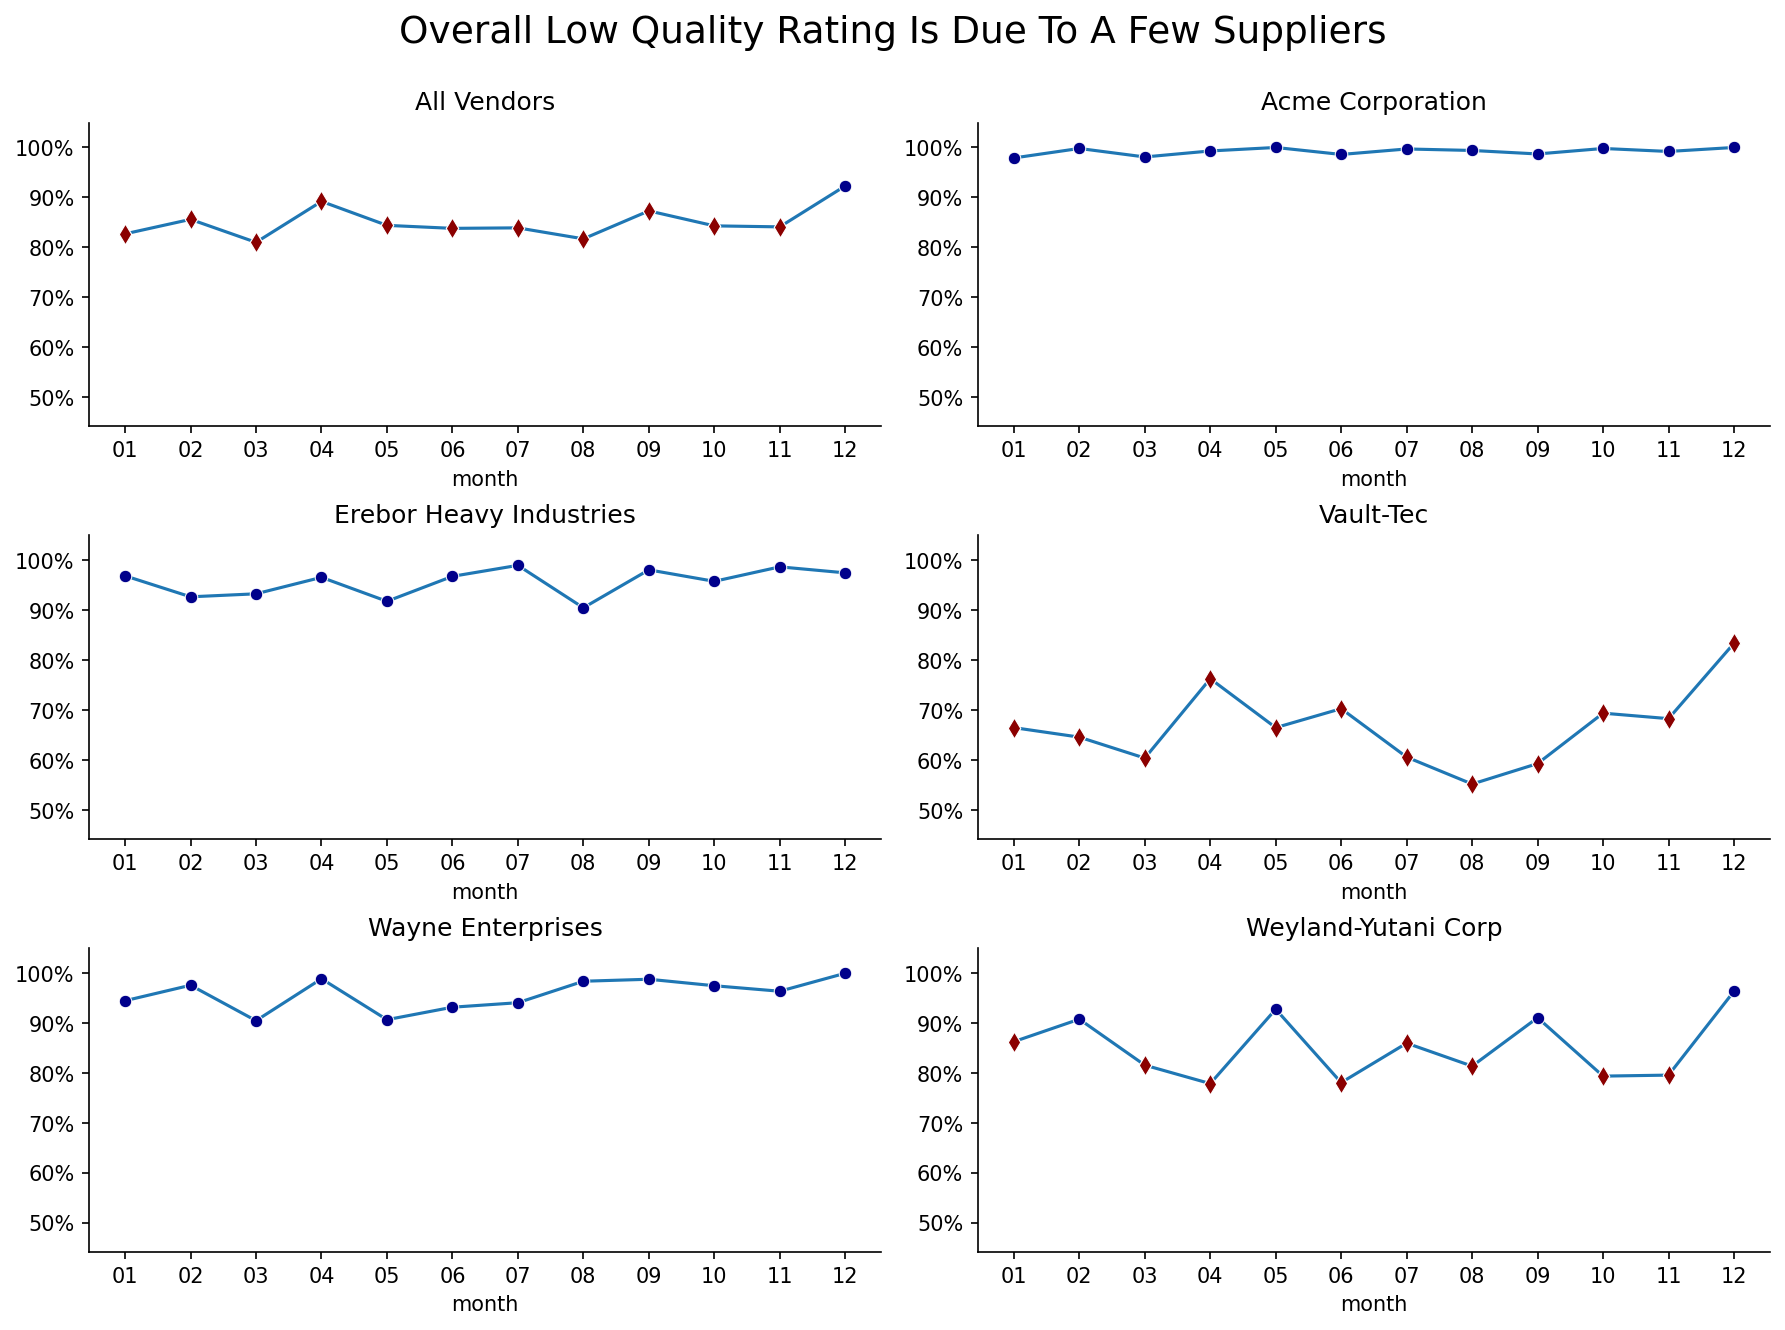

In [196]:
y_min = quality_df['quality_rating'].min() * 0.8
y_max = 1.05
subplot_height = 1.5
vendor_count = len(quality_df['vendor'].unique())

fig, axes = plt.subplots(nrows= 3, ncols=2, figsize=(12, vendor_count * subplot_height))
axes = axes.flatten()

for idx, vendor in enumerate(quality_df['vendor'].unique()):
    plt.ylim(y_min, None)
    df_temp =  quality_df[quality_df['vendor'] == vendor]
    sns.lineplot(data=df_temp, x= 'month', y='quality_rating', ax=axes[idx])
    sns.scatterplot(data=df_temp[df_temp['quality_rating']>=0.90], x= 'month', y='quality_rating', ax=axes[idx], marker='o', color='darkblue', zorder =2)
    sns.scatterplot(data=df_temp[df_temp['quality_rating']<0.90], x= 'month', y='quality_rating', ax=axes[idx], marker='d', color='darkred', zorder =2, s =50)
    axes[idx].set_ylim(y_min, y_max)
    axes[idx].set_ylabel("")
    axes[idx].set_title(f"{vendor}")
    axes[idx].yaxis.set_major_formatter(PercentFormatter(xmax=1))


plt.tight_layout()
plt.suptitle('Overall Low Quality Rating Is Due To A Few Suppliers', fontsize=18)
plt.subplots_adjust(top=0.9)
plt.show()

We can see that our overall supplier rating is not suitable for our needs. Noticeably, Vault-Tec and Weyland-Yutani seem to have the most issues and have pulled down the overall score. Otherwise, no obvious trends are noticeable.

If we hope to mitigate any future risk, we ought to focus our attentions on these two suppliers.

## Checking Quality Rating and Criticality

We've identified two suppliers that could use additional assistance, but not all products are created equally. Some products are more critical to our business than others, so we are interested which vendors can supply highly critical parts with minimum issues.

In [197]:

query = '''
SELECT
    'All Vendors' AS vendor,
    criticality,
    sum(quantity_accepted) AS total_accepted,
    sum(quantity_received) as total_received,
    ROUND(
        sum(quantity_accepted) * 1.0 / sum(quantity_received),
        3) AS quality_rating
FROM summary_view
GROUP BY criticality

UNION ALL

SELECT
    vendor,
    criticality,
    sum(quantity_accepted) AS total_accepted,
    sum(quantity_received) as total_received,
    ROUND(
        sum(quantity_accepted) * 1.0 / sum(quantity_received),
        3) AS quality_rating
FROM summary_view
GROUP BY vendor, criticality
'''
result = %sql {query}

quality_crit_df = result.DataFrame()
quality_crit_df.head(5)

 * sqlite:///synthetic_erp.db
Done.


,vendor,criticality,total_accepted,total_received,quality_rating
0,All Vendors,High,6453,6738,0.958
1,All Vendors,Low,22851,28177,0.811
2,All Vendors,Medium,12548,14605,0.859
3,Acme Corporation,High,2293,2313,0.991
4,Acme Corporation,Low,1873,1889,0.992


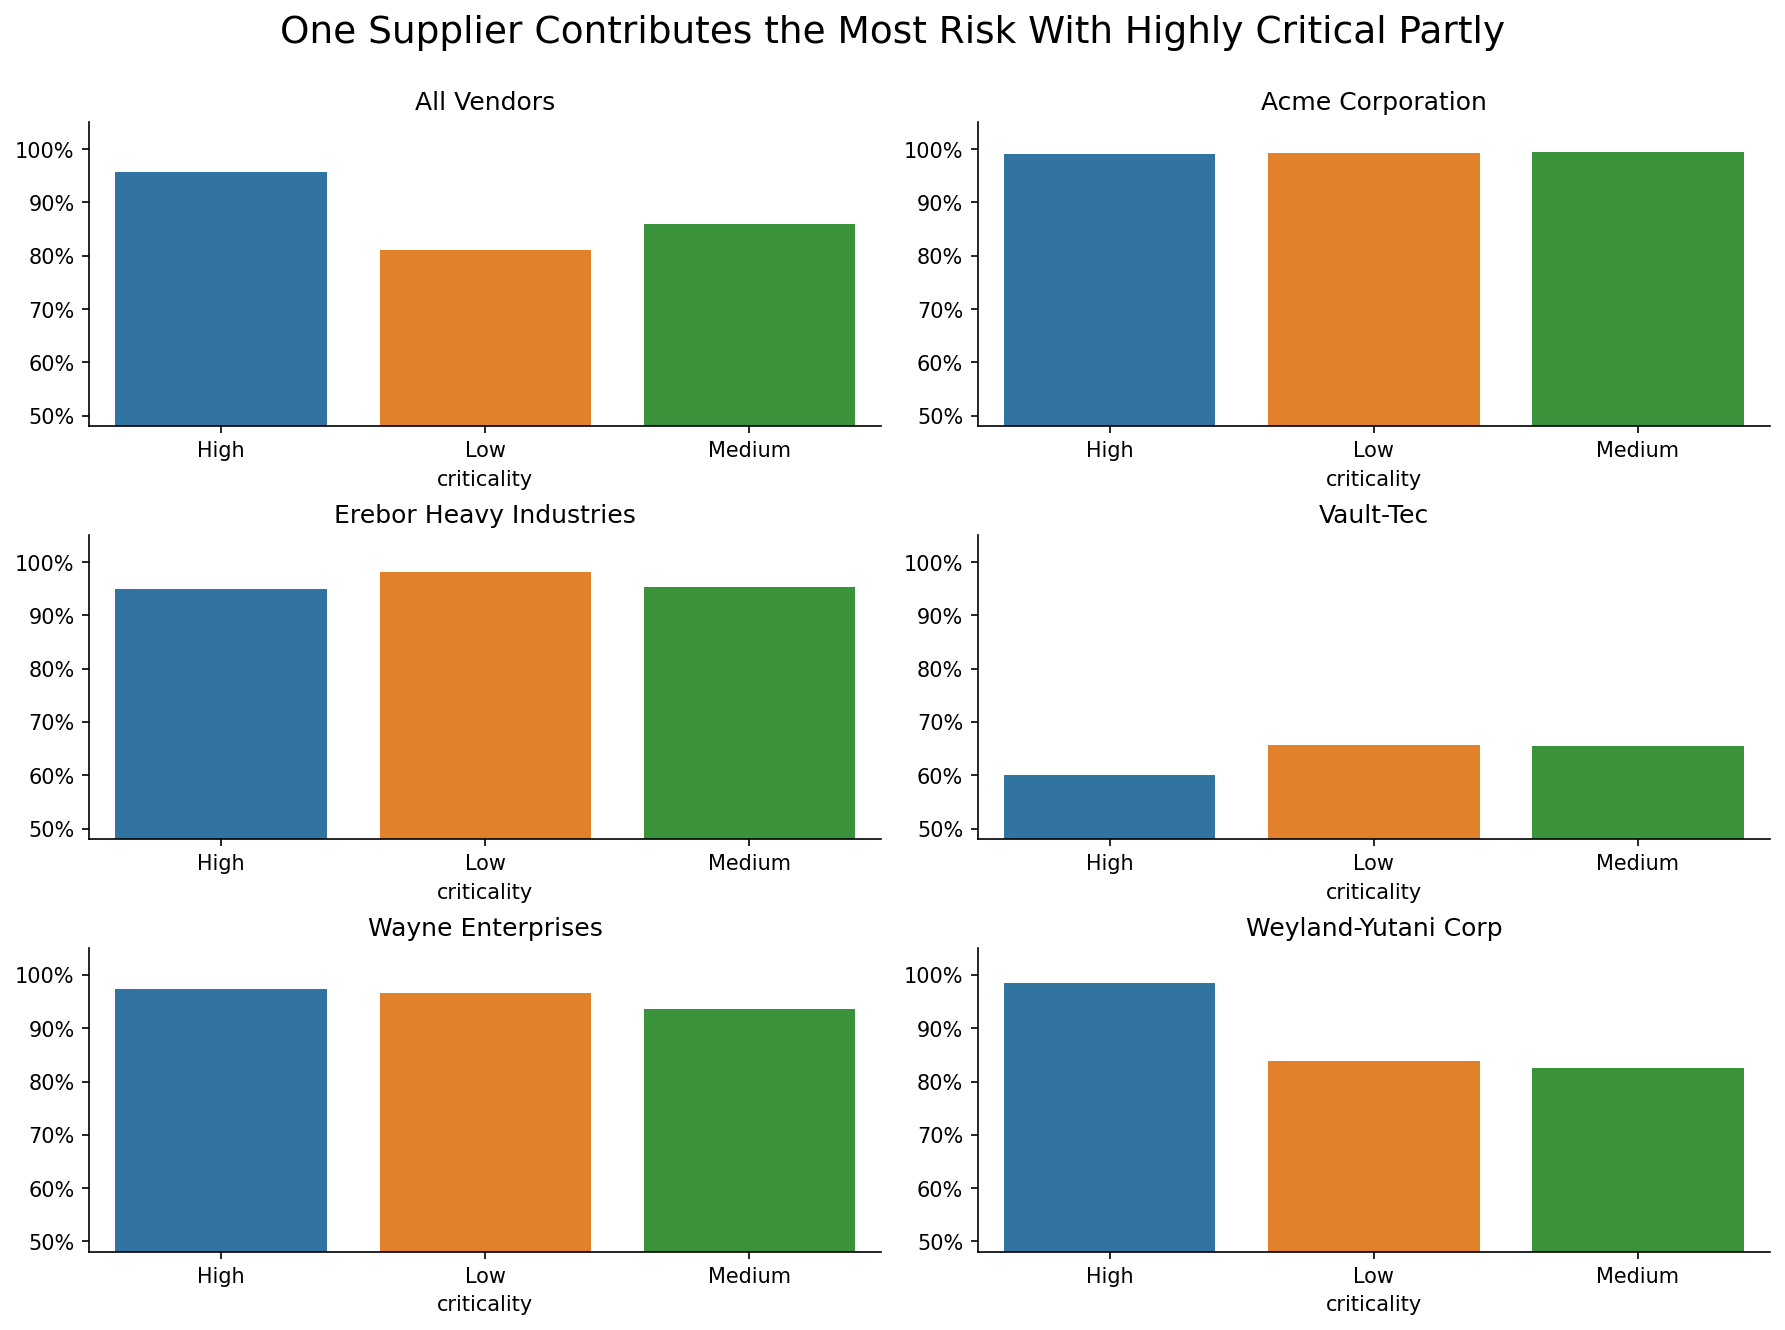

In [198]:
subplot_height = 1.5
fig, axes = plt.subplots(nrows= 3, ncols=2, figsize=(12, vendor_count * subplot_height))
axes = axes.flatten()

y_min = quality_crit_df['quality_rating'].min() * 0.8
y_max = 1.05

for idx, vendor in enumerate(quality_crit_df['vendor'].unique()):
    axes[idx].set_ylim(y_min, None)
    df_temp =  quality_crit_df[quality_crit_df['vendor'] == vendor]
    sns.barplot(data=df_temp, x='criticality', y='quality_rating', hue='criticality', ax=axes[idx], dodge=False)
    axes[idx].set_ylim(y_min, y_max)
    axes[idx].set_ylabel("")
    axes[idx].set_title(f"{vendor}")
    axes[idx].yaxis.set_major_formatter(PercentFormatter(xmax=1))
    axes[idx].legend().remove()

plt.tight_layout()
plt.suptitle('One Supplier Contributes the Most Risk With Highly Critical Partly', fontsize=18)
plt.subplots_adjust(top=0.90)
plt.show()

Vault-Tec has issue with their products regardless of the criticality. This is cause for concern as they introduce risk for all products received from them, especially for highly critical parts.

Weyalnd-Yutani on the other hand, performs well for highly critical parts, but suffers when it comes to medium and low critical parts.

In this situation, our resources are seemingly best spent trying to correct the issues with Vault-Tec first.

## On-Time Delivery
Next, we’ll calculate an on-time delivery (OTD) rating by comparing the receipt date with the due date. This metric measures how consistently suppliers deliver their orders on time.

In [199]:

query = '''
Select 
    'All Vendors' AS vendor,
    strftime('%m', inspection_date) AS month,
    SUM(CASE WHEN received_date > due_date THEN quantity ELSE 0 END) AS qty_late,
    SUM(CASE WHEN received_date <= due_date THEN quantity ELSE 0 END) AS qty_on_time,
    ROUND(
        (SUM(CASE WHEN received_date <= due_date THEN quantity ELSE 0 END) * 1.0) / 
        (SUM(CASE WHEN received_date <= due_date THEN quantity ELSE 0 END) + SUM(CASE WHEN received_date > due_date THEN quantity ELSE 0 END)) 
        ,2)AS otd_rate
    FROM summary_view
GROUP BY month

UNION ALL

Select 
    vendor,
    strftime('%m', inspection_date) AS month,
    SUM(CASE WHEN received_date > due_date THEN quantity ELSE 0 END) AS qty_late,
    SUM(CASE WHEN received_date <= due_date THEN quantity ELSE 0 END) AS qty_on_time,
    ROUND(
        (SUM(CASE WHEN received_date <= due_date THEN quantity ELSE 0 END) * 1.0) / 
        (SUM(CASE WHEN received_date <= due_date THEN quantity ELSE 0 END) + SUM(CASE WHEN received_date > due_date THEN quantity ELSE 0 END)) 
        ,2)AS otd_rate
    FROM summary_view
GROUP BY vendor, month

'''

result = %sql {query}
otd_df = result.DataFrame()


 * sqlite:///synthetic_erp.db
Done.


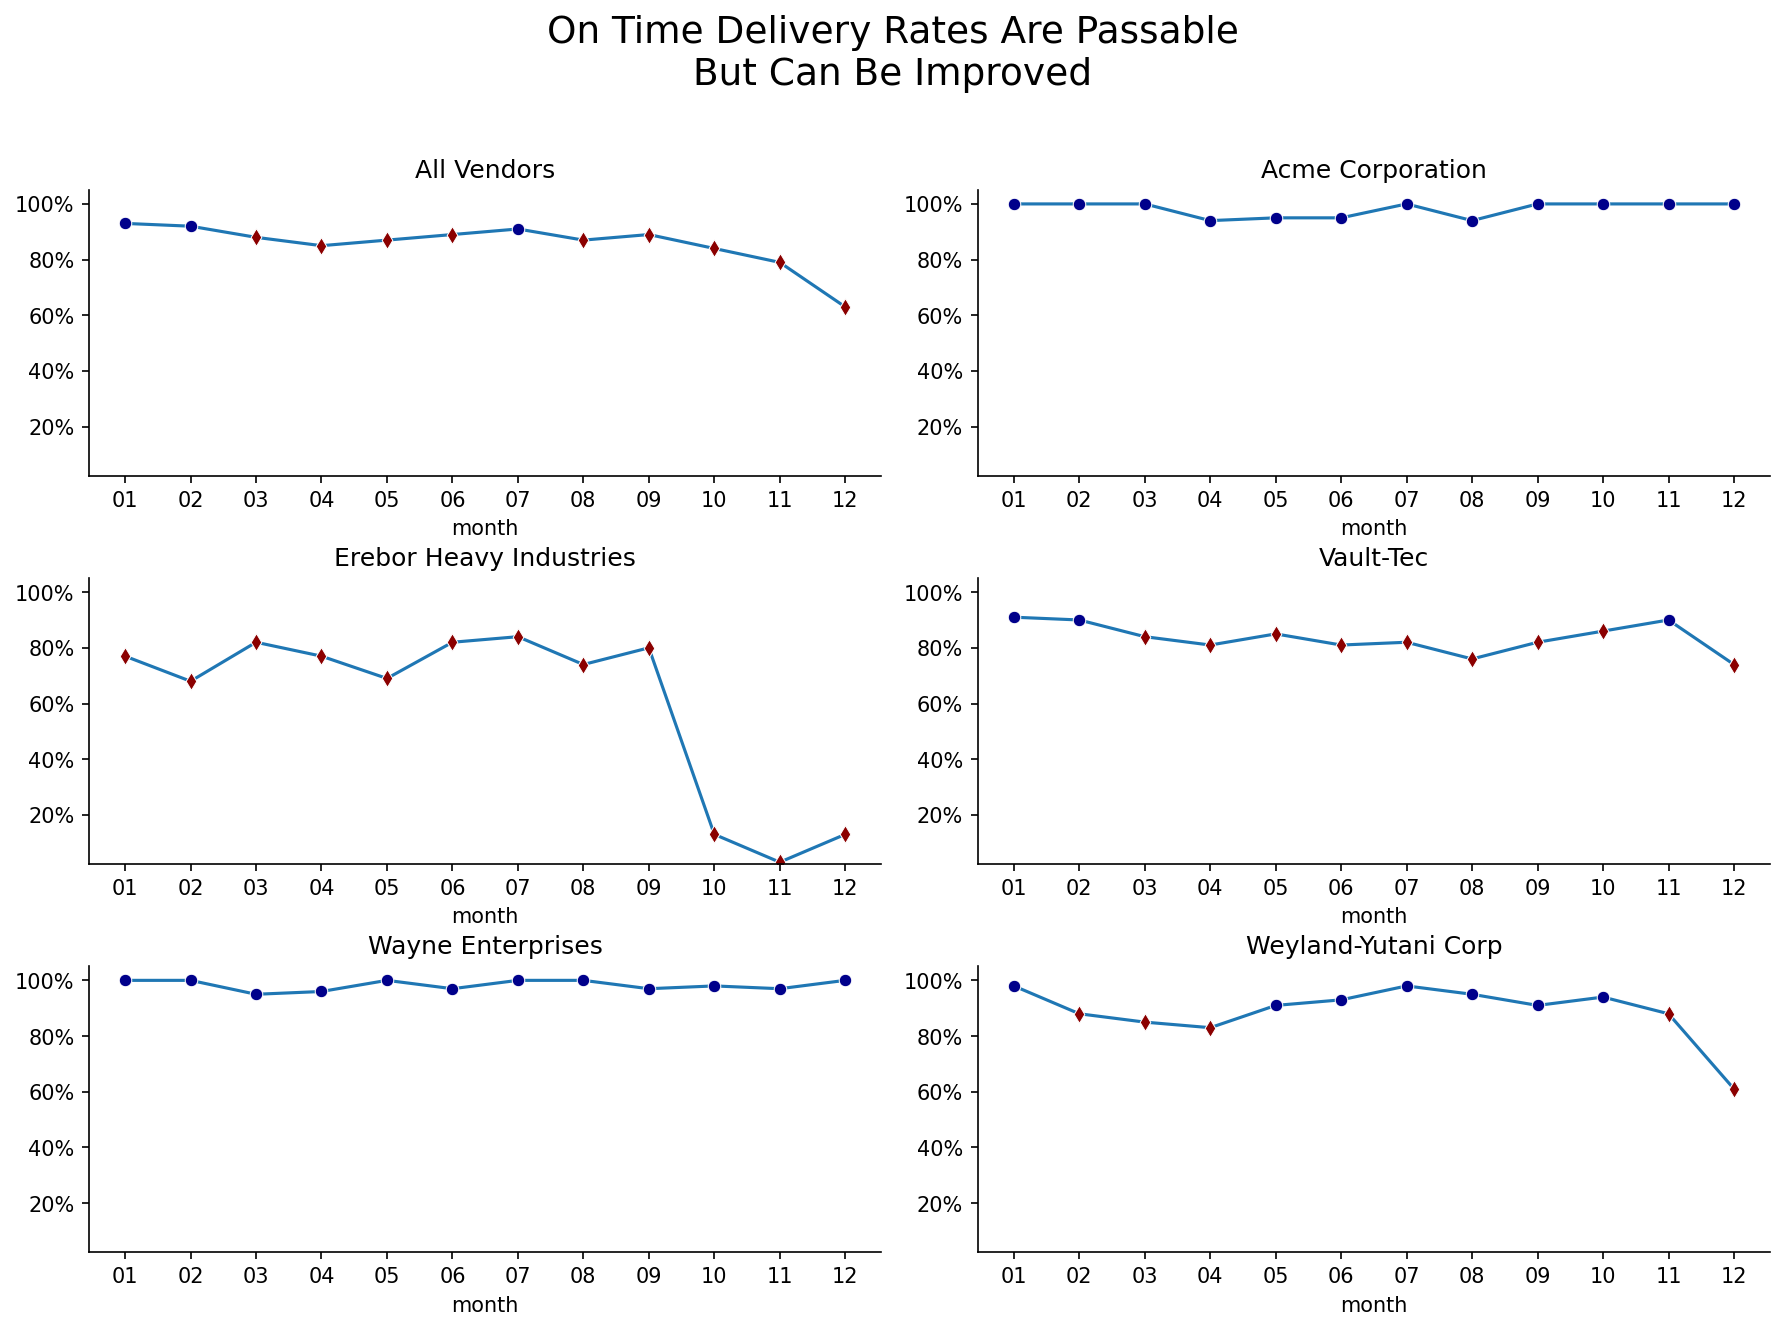

In [200]:
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

vendor_count = len(quality_df['vendor'].unique())
subplot_height = 1.5
fig, axes = plt.subplots(nrows= 3, ncols=2, figsize=(12, vendor_count * subplot_height))
axes = axes.flatten()

y_min = otd_df['otd_rate'].min() * 0.8
y_max = 1.05

for idx, vendor in enumerate(quality_df['vendor'].unique()):
    plt.ylim(y_min, None)
    df_temp =  otd_df[otd_df['vendor'] == vendor]
    sns.lineplot(data=df_temp, x= 'month', y='otd_rate', ax=axes[idx])
    sns.scatterplot(data=df_temp[df_temp['otd_rate']>=0.90], x= 'month', y='otd_rate', ax=axes[idx], marker='o', color='darkblue', zorder =2)
    sns.scatterplot(data=df_temp[df_temp['otd_rate']<0.90], x= 'month', y='otd_rate', ax=axes[idx], marker='d', color='darkred', zorder =2)
    axes[idx].set_ylim(y_min, y_max)
    axes[idx].set_ylabel("")
    axes[idx].set_title(f"{vendor}")
    axes[idx].yaxis.set_major_formatter(PercentFormatter(xmax=1))


plt.tight_layout()
plt.suptitle('On Time Delivery Rates Are Passable\nBut Can Be Improved', fontsize=18)
plt.subplots_adjust(top=0.85)
plt.show()

Our supplier OTD rating has hovered around the 90% mark for the past year and we are looking to improve it. We can see that Erebor Heavy Industries and Vault-Tec have been under-performing, with OTD rates consistently below the 90% threshold. 

In fact, Erebor Heavy Industries has seen a dramatic drop in the months of dying Autumn, namely October into December. This is a risk to our business as they supply us with many critical parts.

_UPDATE: A recent corrective action issued to Erebor Heavy Industries found that they had suffered severe disruption in their operations due an incursion of a northern fire drake. This serves as a clear example of an external threats can disrupt our business operations and the need for additional risk mitigation strategies._

### OTD by Criticality and Vendor
We will visualize the vendors OTD based on the product criticality as well, to gain a insight into each vendors impact to delivering highly critical parts.

In [201]:

query = '''
Select 
    'All Vendors' AS vendor,
    criticality,
    strftime('%m', inspection_date) AS month,
    SUM(CASE WHEN received_date > due_date THEN quantity ELSE 0 END) AS qty_late,
    SUM(CASE WHEN received_date <= due_date THEN quantity ELSE 0 END) AS qty_on_time,
    ROUND(
        (SUM(CASE WHEN received_date <= due_date THEN quantity ELSE 0 END) * 1.0) / 
        (SUM(CASE WHEN received_date <= due_date THEN quantity ELSE 0 END) + SUM(CASE WHEN received_date > due_date THEN quantity ELSE 0 END)) 
        ,2)AS otd_rate
    FROM summary_view
GROUP BY criticality

UNION ALL

Select 
    vendor,
    criticality,
    strftime('%m', inspection_date) AS month,
    SUM(CASE WHEN received_date > due_date THEN quantity ELSE 0 END) AS qty_late,
    SUM(CASE WHEN received_date <= due_date THEN quantity ELSE 0 END) AS qty_on_time,
    ROUND(
        (SUM(CASE WHEN received_date <= due_date THEN quantity ELSE 0 END) * 1.0) / 
        (SUM(CASE WHEN received_date <= due_date THEN quantity ELSE 0 END) + SUM(CASE WHEN received_date > due_date THEN quantity ELSE 0 END)) 
        ,2)AS otd_rate
    FROM summary_view
GROUP BY vendor, criticality

'''

result = %sql {query}
otd_crit_df = result.DataFrame()
otd_crit_df.head(10)

 * sqlite:///synthetic_erp.db
Done.


,vendor,criticality,month,qty_late,qty_on_time,otd_rate
0,All Vendors,High,12,4172,21524,0.84
1,All Vendors,Low,12,12793,100729,0.89
2,All Vendors,Medium,12,8706,47668,0.85
3,Acme Corporation,High,01,97,8573,0.99
4,Acme Corporation,Low,02,180,7432,0.98
5,Acme Corporation,Medium,01,95,3995,0.98
6,Erebor Heavy Industries,High,01,3890,5789,0.60
7,Erebor Heavy Industries,Low,12,1881,3072,0.62
8,Erebor Heavy Industries,Medium,12,4934,10228,0.67
9,Vault-Tec,High,02,81,1203,0.94


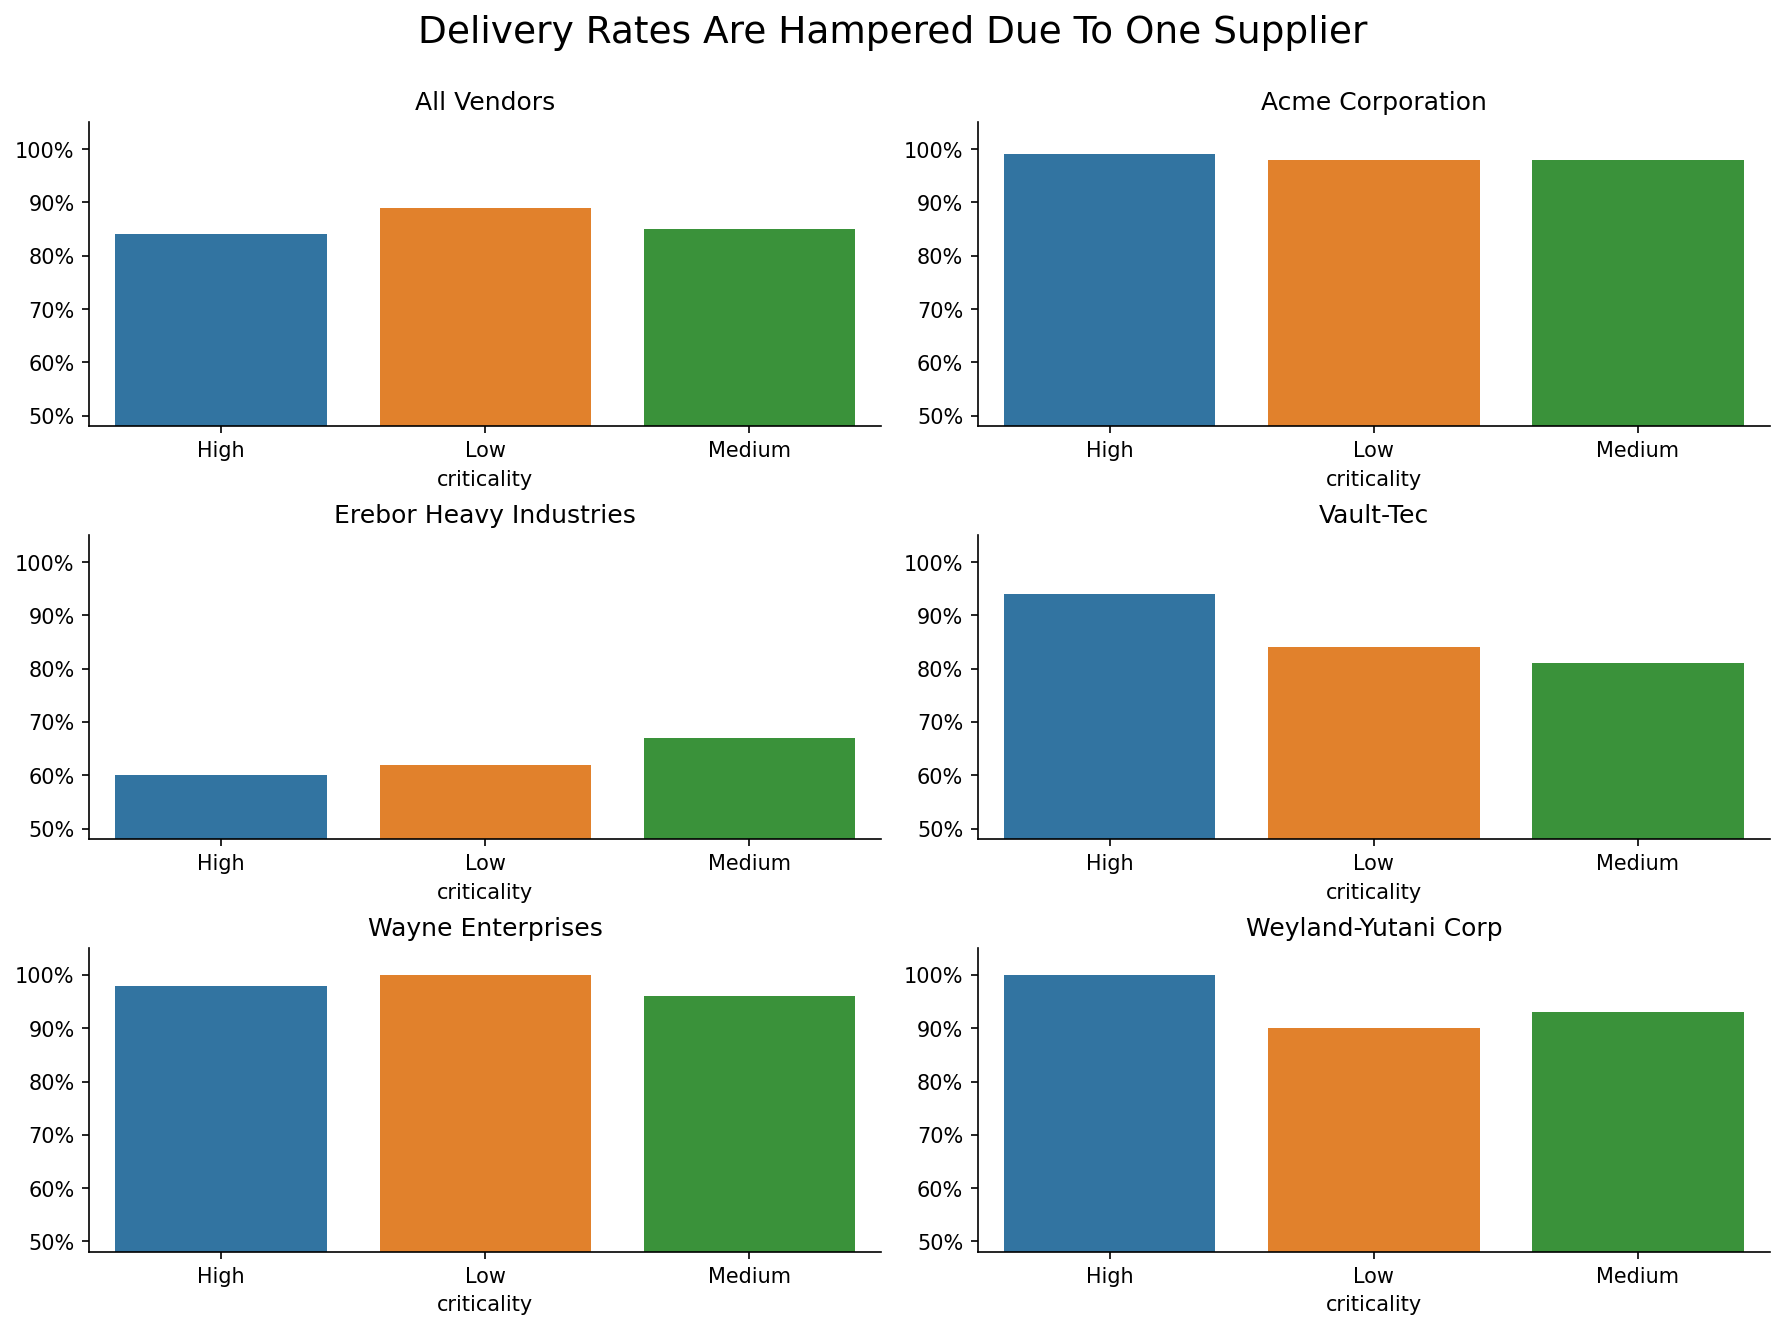

In [202]:
subplot_height = 1.5
fig, axes = plt.subplots(nrows= 3, ncols=2, figsize=(12, vendor_count * subplot_height))
axes = axes.flatten()

y_min = otd_crit_df['otd_rate'].min() * 0.8
y_max = 1.05

for idx, vendor in enumerate(otd_crit_df['vendor'].unique()):
    axes[idx].set_ylim(y_min, None)
    df_temp =  otd_crit_df[otd_crit_df['vendor'] == vendor]
    sns.barplot(data=df_temp, x='criticality', y='otd_rate', hue='criticality', ax=axes[idx], dodge=False)
    axes[idx].set_ylim(y_min, y_max)
    axes[idx].set_ylabel("")
    axes[idx].set_title(f"{vendor}")
    axes[idx].yaxis.set_major_formatter(PercentFormatter(xmax=1))
    axes[idx].legend().remove()

plt.tight_layout()
plt.suptitle('Delivery Rates Are Hampered Due To One Supplier', fontsize=18)
plt.subplots_adjust(top=0.90)
plt.show()

Vault-Tec has acceptable OTD when it come to delivery high criticality products, however their OTD rating suffered when it comes to fulfilling products of lower importance.

Our efforts are then better suited to addressing the issues with Erebor Heavy Industries, which had lackluster delivery rates even before the recent issues. 

## 5. Supplier Risk Matrix

Overall, we have two candidates for improvements: Vaul-Tec due to low quality ratings, and Erebor Heavy Industries due to low delivery rates. 

We'll need to determine which supplier to prioritize and to do so we'll create a risk matrix, a common tool used across many industries, by classifying vendor quality and OTD ratings into these categories:
* Low Risk - \> 90%
* Medium Risk - < 90%
* High Risk - < 80%

This classification is easily done with SQL as well, by using the CASE keyword.

In [203]:
query = '''
SELECT 
    vendor,
    ROUND(
        (SUM(CASE WHEN received_date <= due_date THEN quantity ELSE 0 END) * 1.0) / 
        (SUM(CASE WHEN received_date <= due_date THEN quantity ELSE 0 END) + SUM(CASE WHEN received_date > due_date THEN quantity ELSE 0 END)), 
    2) AS otd_rate,

    ROUND(
        SUM(quantity_accepted) * 1.0 / SUM(quantity_received), 
    3) AS quality_rating,

    CASE
        WHEN 
            (SUM(CASE WHEN received_date <= due_date THEN quantity ELSE 0 END) * 1.0) / 
            (SUM(CASE WHEN received_date <= due_date THEN quantity ELSE 0 END) + SUM(CASE WHEN received_date > due_date THEN quantity ELSE 0 END)) < 0.80 
        THEN 'HIGH RISK'
        WHEN 
            (SUM(CASE WHEN received_date <= due_date THEN quantity ELSE 0 END) * 1.0) / 
            (SUM(CASE WHEN received_date <= due_date THEN quantity ELSE 0 END) + SUM(CASE WHEN received_date > due_date THEN quantity ELSE 0 END)) < 0.90 
        THEN 'MEDIUM RISK'
        ELSE 'LOW RISK'
    END AS OTD_RISK,

    CASE
        WHEN SUM(quantity_accepted) * 1.0 / SUM(quantity_received) < 0.80 THEN 'HIGH RISK'
        WHEN SUM(quantity_accepted) * 1.0 / SUM(quantity_received) < 0.90 THEN 'MEDIUM RISK'
        ELSE 'LOW RISK'
    END AS Q_RISK
    
FROM summary_view
GROUP BY vendor'''

result = %sql {query}
risk_matrix = result.DataFrame()
risk_matrix


 * sqlite:///synthetic_erp.db
Done.


,vendor,otd_rate,quality_rating,OTD_RISK,Q_RISK
0,Acme Corporation,0.98,0.992,LOW RISK,LOW RISK
1,Erebor Heavy Industries,0.64,0.957,HIGH RISK,LOW RISK
2,Vault-Tec,0.84,0.655,MEDIUM RISK,HIGH RISK
3,Wayne Enterprises,0.98,0.956,LOW RISK,LOW RISK
4,Weyland-Yutani Corp,0.91,0.839,LOW RISK,MEDIUM RISK


The query has classified our vendors metrics into their respective risk categories. We'll create a risk matrix through use of custom visualization to properly visualize how each vendors stacks up. 

In [204]:
from numpy import zeros_like
import pandas as pd

row_order = ['LOW RISK', 'MEDIUM RISK', 'HIGH RISK'] 
col_order = ['HIGH RISK', 'MEDIUM RISK', 'LOW RISK'] 

risk_matrix['Q_RISK'] = pd.Categorical(risk_matrix['Q_RISK'], categories=col_order, ordered=True)
risk_matrix['OTD_RISK'] = pd.Categorical(risk_matrix['OTD_RISK'], categories=row_order, ordered=True)
pivot = risk_matrix.groupby(['Q_RISK', 'OTD_RISK'])['vendor'].apply(lambda x: '\n'.join(x)).unstack()
pivot = pivot.fillna('')
pivot

OTD_RISK,LOW RISK,MEDIUM RISK,HIGH RISK
Q_RISK,,,
HIGH RISK,,Vault-Tec,
MEDIUM RISK,Weyland-Yutani Corp,,
LOW RISK,Acme Corporation\nWayne Enterprises,,Erebor Heavy Industries


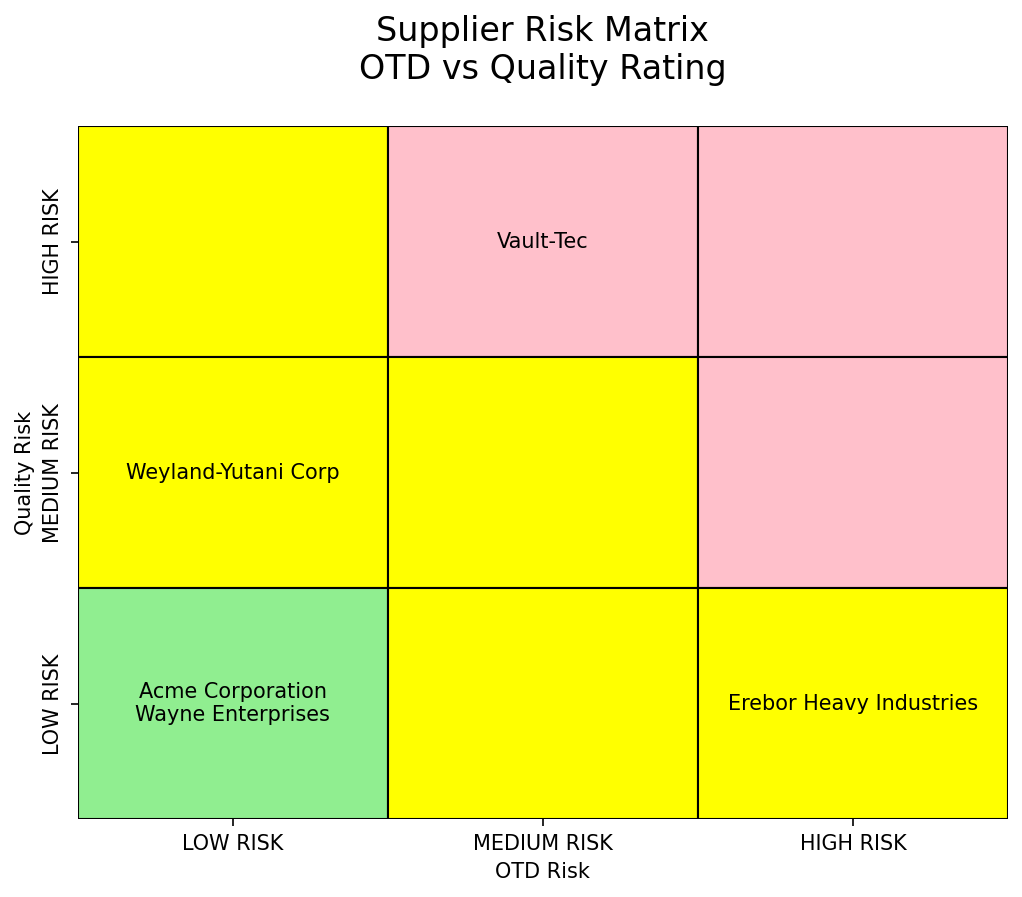

In [205]:
color_map = {
    ('LOW RISK', 'LOW RISK'): 'lightgreen',
    ('LOW RISK', 'MEDIUM RISK'): 'yellow',
    ('LOW RISK', 'HIGH RISK'): 'yellow',
    ('MEDIUM RISK', 'LOW RISK'): 'yellow',
    ('MEDIUM RISK', 'MEDIUM RISK'): 'yellow',
    ('MEDIUM RISK', 'HIGH RISK'): 'pink',
    ('HIGH RISK', 'LOW RISK'): 'yellow',
    ('HIGH RISK', 'HIGH RISK'): 'pink',
    ('HIGH RISK', 'MEDIUM RISK'): 'pink'
}

plt.figure(figsize=(8, 6))
sns.heatmap(zeros_like(pivot, dtype=float), 
            annot=pivot, fmt='', 
            cbar=False, 
            annot_kws={"color": "black"}
            )

ax = plt.gca()

for i in range(pivot.shape[0]):  
    for j in range(pivot.shape[1]): 
        quality_risk = pivot.index[i]  
        otd_risk = pivot.columns[j]   
        cell_color = color_map.get((quality_risk, otd_risk))
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor=cell_color, lw=1, edgecolor ='black'))


plt.title('Supplier Risk Matrix\nOTD vs Quality Rating',fontsize=16,y=1.05)
plt.xlabel('OTD Risk')
plt.ylabel('Quality Risk')
plt.gca().set_xticklabels(['LOW RISK','MEDIUM RISK','HIGH RISK' ])
plt.gca().set_yticklabels(['HIGH RISK', 'MEDIUM RISK', 'LOW RISK', ])

plt.show()

## 6. Summary

Now that we have a proper risk matrix, it is clear that we should prioritize our attention on Vault-Tec, as they pose the highest immediate risk to the company based on our classification. Vault-Tec stands out as a high-risk supplier due to their consistently low on-time delivery and quality ratings, indicating potential systemic issues with their processes.

By leveraging SQL to automate data extraction and analysis, we transformed raw data into actionable insights, enabling us to proactively manage our suppliers. The use of SQL to generate these key metrics allows us to create reusable data pipelines, facilitating other team members or processes to pull and use this information as needed.

## 7. Bonus Analysis
We should consider that a single on-time order of 20 parts in January isn't as significant as 19 on-time orders of 500 parts each. The OTD rates can be misleading when it ignores the total volume received. We'll will take this into account next by exploring the likelihood that order of highly critical parts will arrive late during our top 4 busiest months. 



### Retrieval

Our first query uses OVER and PARTITION BY keywords to perform window calculations to determine the % of late orders per month, ordered by the total number of parts received.

In [206]:
%%sql
SELECT
    strftime('%m', received_date) AS month,
    CASE
        WHEN received_date > due_date THEN 'Late'
        ELSE 'On Time'
        END AS delivery_status,
    COUNT(*) AS total_orders,
    ROUND(COUNT(*) * 1.0 / SUM(COUNT(*)) OVER (PARTITION BY strftime('%m', received_date)), 2) AS percentage_of_total
    FROM summary_view
    WHERE criticality = 'High'
GROUP BY month, delivery_status;

 * sqlite:///synthetic_erp.db
Done.


month,delivery_status,total_orders,percentage_of_total
01,Late,1,0.04
01,On Time,26,0.96
02,On Time,19,1.0
03,Late,7,0.13
03,On Time,45,0.87
04,Late,6,0.2
04,On Time,24,0.8
05,Late,3,0.06
05,On Time,44,0.94
06,Late,3,0.08


The 2nd query calculates retrieves the top 4 months ordered by total quantity received.

In [207]:
%%sql
SELECT
    strftime('%m', received_date) as month,
    sum(quantity_received) as monthly_quantity_received
FROM summary_view

GROUP BY month
ORDER BY sum(quantity_received) desc
LIMIT 4;

 * sqlite:///synthetic_erp.db
Done.


month,monthly_quantity_received
07,5683
10,4997
05,4809
08,4777


The 5th, 7th, 8th, and 10th months of the year were our busiest months to receive high-critical parts. We will use this data to filter the months of the first query.

In [208]:
query = '''
SELECT
    strftime('%m', received_date) AS month,
    CASE
        WHEN received_date > due_date THEN 'Late'
        ELSE 'On Time'
        END AS delivery_status,
    COUNT(*) AS total_orders,
    ROUND(COUNT(*) * 1.0 / SUM(COUNT(*)) OVER (PARTITION BY strftime('%m', received_date)), 3) AS percentage_of_total
    FROM summary_view
    WHERE criticality = 'High' AND month IN (
        SELECT
            strftime('%m', received_date) as month
            FROM summary_view
            GROUP BY month
            ORDER BY sum(quantity_received) desc
            LIMIT 4
            )
GROUP BY month, delivery_status;'''

result = %sql {query}

orders_over_500_df = result.DataFrame()
orders_over_500_df


 * sqlite:///synthetic_erp.db
Done.


,month,delivery_status,total_orders,percentage_of_total
0,05,Late,3,0.064
1,05,On Time,44,0.936
2,07,Late,2,0.044
3,07,On Time,43,0.956
4,08,Late,4,0.095
5,08,On Time,38,0.905
6,10,Late,10,0.323
7,10,On Time,21,0.677


The results are as expected. The only the 5th, 7th, 8th, and 10th months are shown, and we have the likelihood that an order will be late. To help visualize this, we will create a 100% stacked bar chart.

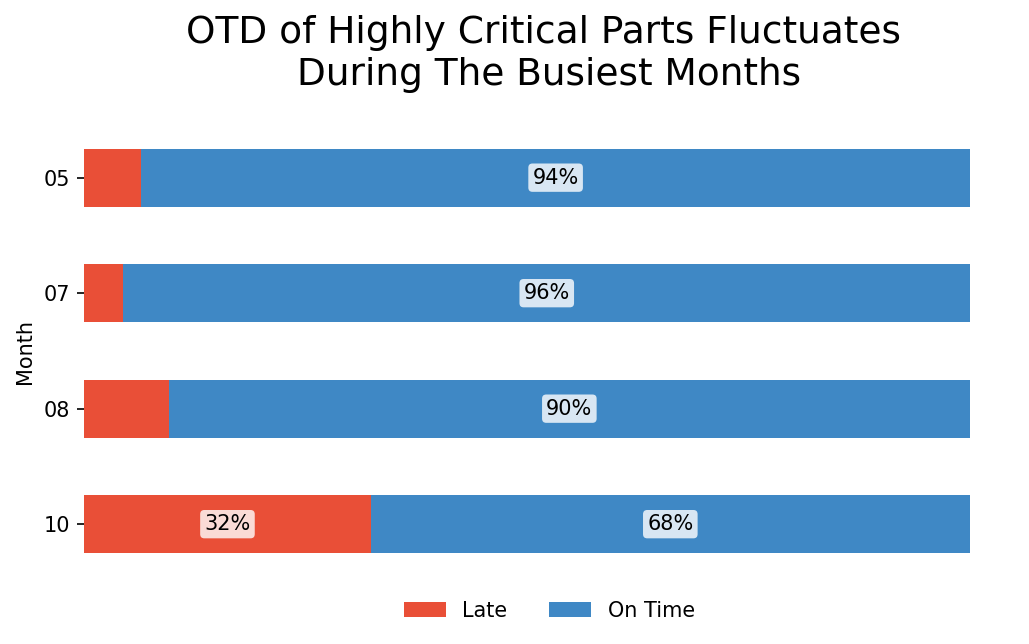

In [209]:
from matplotlib.ticker import PercentFormatter
# pivot table to have delivery status in columns. Keep only the 'percentage_of_total' value
pivot_df = orders_over_500_df.pivot(index='month', columns='delivery_status', values='percentage_of_total')

# Pivot the data to have criticality levels as columns
# pivot_df = orders_over_500_df.pivot_table(
#     index='month', 
#     columns='delivery_status', 
#     values='percentage_of_total', 
#     aggfunc='sum'
# )
pivot_df
axis = pivot_df.plot(
    kind='barh',
    stacked=True,
    color=['#E94F37', '#3F88C5'],
    figsize=(8, 4)
)

for container in axis.containers:
    for bar in container:
        width = bar.get_width()
        if width > 0.10:
            x_pos = bar.get_x() + width / 2
            y_pos = bar.get_y() + bar.get_height() /2
            axis.text(
                x_pos,
                y_pos,
                f'{width:.0%}',
                ha='center',
                va='center',
                fontweight='normal',
                color='black',
                bbox=dict(facecolor='#ffffff', 
                          edgecolor='None', 
                          boxstyle='round,pad=0.2',
                          alpha=0.80) 
            )

plt.title('OTD of Highly Critical Parts Fluctuates \nDuring The Busiest Months', fontsize =18, y = 1.05)
plt.xlabel('')
plt.ylabel('Month')
plt.gca().invert_yaxis()

axis.xaxis.set_major_formatter(PercentFormatter(1.0))
axis.legend(loc='upper center', bbox_to_anchor=(0.5, 0.00), ncol=3, frameon=False)
axis.spines['bottom'].set_visible(False)
axis.spines['left'].set_visible(False)
axis.tick_params(bottom=False, labelbottom=False)


plt.show()


### Findings
Overall, during the top 4 busiest months of the year, highly critical parts tend to meet our expectation of 90% OTD rate or higher. The noticeable exception is October, which we determined to be the result of some political instability in the region. 

In any case, we where able to drill down and create an more specific analysis of the data, focusing on a time frame our our choosing and evaluating the risks to the business